# Inital imports

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import PIL
import imgaug


seed = 777
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.3.1
0.4.2


In [3]:
!nvidia-smi

Sat Jan  4 09:32:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Required library versions 
The newest version of Pillow and imgaug are needed. Please read the output of the following installs. The usually need several restarts and reexecutions of the runtime until all requirements are fullfilled.
It has to say: "Requirement already satisfied[...]"

In [4]:
!pip install Pillow==6.2.1

In [5]:
!pip install imgaug==0.3.0

# Hyper-Parameters for training

In [0]:
N_EPOCHS = 50
BATCH_SIZE = 32 #This also affects the batch size of saved tensor batches in preprocessing step.
LEARNING_RATE = 0.00025
DROPOUT_SMALLNET = 0.75

VAL_LOADER_BATCH_SIZE = 8;

# Check versions of crucial libraries

Should be:
1.3.1,
1.17.4,
0.4.2,
6.2.1,
0.3.0,



In [7]:
print(torch.__version__)
print(np.__version__)
print(torchvision.__version__)
print(PIL.__version__)
print(imgaug.__version__)

1.3.1
1.17.4
0.4.2
6.2.1
0.3.0


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


# Preprocess and generate images
The following code generates augmentations as a preprocess step with different approaches of adding augmentations. The goal of this is to enhance the training set with this augmented data. The norm dataset will only contain the unaugmented images. The other datasets hold the norm data plus the augmentations additionally.

This is done in a preprocessed step and saved locally to speed up the training, since the training with live augmentation takes a long time. This approach however might not be a good choice in practive because the augmentations are static after preprocessing. So this speeds up training for the purpose of showing augmentation techniques, but while training your model you may rather have augmentations on the fly at training time with random generation.

## Augmentation : Pytorch (simple)

In [0]:
import PIL

transform_pytorch = torchvision.transforms.Compose([
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomResizedCrop(32),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(90, resample=PIL.Image.BILINEAR),
])

## Augmentation: imgaug 

In [0]:
import numpy as np
import imgaug as ia
from imgaug import augmenters as iaa

class ImgAugTransform:
    def __init__(self):
        # Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
        # e.g. Sometimes(0.5, GaussianBlur(0.3)) would blur roughly every second image.
        sometimes = lambda t: iaa.Sometimes(0.5, t)


        # Define our sequence of augmentation steps that will be applied to every image
        # All augmenters with per_channel=0.5 will sample one value _per image_
        # in 50% of all cases. In all other cases they will sample new values
        # _per channel_.
        self.aug = iaa.Sequential(
            [
                iaa.OneOf([
                    # apply the following augmenters to most images
                    iaa.Fliplr(0.5), # horizontally flip 50% of all images
                    #iaa.Flipud(0.2), # vertically flip 20% of all images

                    iaa.Sometimes(0.33, iaa.GaussianBlur(sigma=(0, 3.0))),
                    iaa.Sometimes(0.33, iaa.Affine(rotate=(-20, 20), mode='symmetric')),
                    iaa.Sometimes(0.33, iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)),
                ]),
                # apply the following augmenters to most images
                iaa.Fliplr(0.5), # horizontally flip 50% of all images
                #iaa.Flipud(0.2), # vertically flip 20% of all images
                
                iaa.Sometimes(0.2, iaa.GaussianBlur(sigma=(0, 3.0))),
                iaa.Sometimes(0.2, iaa.Affine(rotate=(-20, 20), mode='symmetric')),
                iaa.Sometimes(0.2, iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)),
                iaa.Sometimes(0.25,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout(0.1, size_percent=0.5)])),
        
                
                #crop images by -5% to 10% of their height/width
                sometimes(iaa.CropAndPad(
                    percent=(-0.05, 0.1),
                    pad_mode=ia.ALL,
                    pad_cval=(0, 255)
                )),
                sometimes(iaa.Affine(
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                    rotate=(-45, 45), # rotate by -45 to +45 degrees
                    shear=(-16, 16), # shear by -16 to +16 degrees
                    order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                    cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                    mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
                )),
                # execute 0 to 5 of the following (less important) augmenters per image
                # don't execute all of them, as that would often be way too strong
                iaa.SomeOf((0, 5),
                    [
                        sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                        iaa.OneOf([
                            iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                            iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                            iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                        ]),
                        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                        iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                        # search either for all edges or for directed edges,
                        # blend the result with the original image using a blobby mask
                        iaa.SimplexNoiseAlpha(iaa.OneOf([
                            iaa.EdgeDetect(alpha=(0.5, 1.0)),
                            iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                        ])),
                        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                        iaa.OneOf([
                            iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                            iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                        ]),
                        iaa.Invert(0.05, per_channel=True), # invert color channels
                        iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                        iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                        # either change the brightness of the whole image (sometimes
                        # per channel) or change the brightness of subareas
                        iaa.OneOf([
                            iaa.Multiply((0.5, 1.5), per_channel=0.5),
                            iaa.FrequencyNoiseAlpha(
                                exponent=(-4, 0),
                                first=iaa.Multiply((0.5, 1.5), per_channel=True),
                                second=iaa.LinearContrast((0.5, 2.0))
                            )
                        ]),
                        iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                        iaa.Grayscale(alpha=(0.0, 1.0)),
                        sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                        sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                        sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                    ],
                    random_order=True
                )
            ],
            random_order=True
        )
    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

transform_imgaug = ImgAugTransform()


## Augmentation: autoaugment

In [11]:
!git clone https://github.com/4uiiurz1/pytorch-auto-augment pytorchAutoAugment

from pytorchAutoAugment.auto_augment import AutoAugment
from pytorchAutoAugment.auto_augment import Cutout

transform_autoaugment = transforms.Compose([
    AutoAugment(),
    #Cutout(),
])

Cloning into 'pytorchAutoAugment'...
remote: Enumerating objects: 20, done.
remote: Total 20 (delta 0), reused 0 (delta 0), pack-reused 20
Unpacking objects: 100% (20/20), done.


# Prepare the data

In [12]:
#The compose function allows for multiple transforms
#transforms.ToTensor() converts our PILImage to a tensor of shape (C x H x W) in the range [0,1]
#transforms.Normalize(mean,std) normalizes a tensor to a (mean, std) for (R, G, B)

transform_tensor_norm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_imgaug_norm = transforms.Compose([transform_imgaug, transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_pytorch_norm = transforms.Compose([transform_pytorch, transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#transform_albumentations_norm = transforms.Compose([transform_albumentations, transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_autoaugment_norm = transforms.Compose([transform_autoaugment, transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_set_norm = torchvision.datasets.CIFAR10(root='./cifardata', train=True, download=True, transform=transform_tensor_norm)
train_set_imgaug = torchvision.datasets.CIFAR10(root='./cifardata', train=True, download=True, transform=transform_imgaug_norm)
train_set_pytorch = torchvision.datasets.CIFAR10(root='./cifardata', train=True, download=True, transform=transform_pytorch_norm)
#train_set_albumentations = torchvision.datasets.CIFAR10(root='./cifardata', train=True, download=True, transform=transform_albumentations_norm)
train_set_autoaugment = torchvision.datasets.CIFAR10(root='./cifardata', train=True, download=True, transform=transform_autoaugment_norm)


test_set = torchvision.datasets.CIFAR10(root='./cifardata', train=False, download=True, transform=transform_tensor_norm)


0it [00:00, ?it/s]

170500096it [00:04, 42352281.04it/s]                               


Extracting ./cifardata/cifar-10-python.tar.gz to ./cifardata
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [0]:
dataset_norm = train_set_norm

dataset_imgaug = train_set_imgaug

dataset_pytorch = train_set_pytorch

dataset_autoaugment = train_set_autoaugment

In [0]:
trainsets = {'norm' : dataset_norm, 'imgaug' : dataset_imgaug, 'pytorch' : dataset_pytorch, 'autoaugment' : dataset_autoaugment}
#trainsets = {'norm' : dataset_norm, 'imgaug' : dataset_imgaug, 'pytorch' : dataset_pytorch, 'autoaugment' : dataset_autoaugment}
#trainsets = {'pytorch' : dataset_pytorch}


# Note on preprocessing:
The following code does the preprocessing of the augmentation. If there is an error with numpy strides, restart the runtime and make sure the corrent versions of the libraries are actually installed. If this is the case the stride error shouldn't come up.

|Also this takes about 20 minutes.

In [15]:
import os

PREPROCESS = True

if PREPROCESS:

  parent_dir = './preprocessed_data'

  try:
    # Create target Directory
    os.mkdir(parent_dir)
    print("Directory " , parent_dir ,  " Created ") 
  except FileExistsError:
    print("Directory " , parent_dir ,  " already exists")






  for key in trainsets:

      print('Preprocessing augmentations {}'.format(key))

      #Use the data loader
      train_loader = torch.utils.data.DataLoader(trainsets[key], batch_size=BATCH_SIZE,
                                          num_workers=0)
      #train_loader = get_train_loader(BATCH_SIZE, trainsets[key])

      dirName = key

      try:
          # Create target Directory
          os.mkdir(parent_dir + '/' + dirName)
          print("Directory " , dirName ,  " Created ") 
      except FileExistsError:
          print("Directory " , dirName ,  " already exists")

      #Save the dataset batch-wise
      for idx, data in enumerate(train_loader, 0):
          torch.save(data, '{}/{}/{}'.format(parent_dir, key, idx))

  
  

Directory  ./preprocessed_data  Created 
Preprocessing augmentations norm
Directory  norm  Created 
Preprocessing augmentations imgaug
Directory  imgaug  Created 
Preprocessing augmentations pytorch
Directory  pytorch  Created 
Preprocessing augmentations autoaugment
Directory  autoaugment  Created 


In [0]:
#DataLoader takes in a dataset and a sampler for loading (num_workers deals with system level memory) 
from torch.utils.data.sampler import RandomSampler
def get_train_loader(batch_size, train_set):
    train_sampler = SubsetRandomSampler(np.arange(len(train_set), dtype=np.int64))
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                                           num_workers=0)
    
    return(train_loader)

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler

#DataLoader takes in a dataset and a sampler for loading (num_workers deals with system level memory) 
def get_preprocessed_train_loader(train_set):
  n_pre_training_samples = len(train_set)
  train_pre_sampler = SubsetRandomSampler(np.arange(n_pre_training_samples, dtype=np.int64))
  #Batch size is one because we already saved them as batches. So one loaded batch here is equal to the amount of batch size as paramter.
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=1,
                                           sampler=train_pre_sampler, num_workers=0)
  return(train_loader)

# Preprocess the data with augmentation.
To spare the augmentation from being applied on every loading during training, preprocessing is done once.
With this, the random effect of some augmentation is gone to a static one though.

In [0]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [0]:
#Copy the data over to colab
#!cp -r /content/gdrive/'My Drive'/preprocessed_data.zip .

In [0]:
#unpack the archive
#!unzip preprocessed_data.zip

In [0]:
#Check if preprocessed directories are mounted
!ls preprocessed_data


autoaugment  imgaug  norm  pytorch


# SmallNet
I implemented this small net based on the given paper for the seminar. This is just a very simple 3 layer CNN.

In [0]:

from torch.autograd import Variable
import torch.nn.functional as F

class SmallNet(torch.nn.Module):
    
    #Our batch shape for input x is (3, 32, 32)
    
    def __init__(self):
        super(SmallNet, self).__init__()
        
        #Input channels = 3, output channels = 18
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        
        self.conv1_bn = torch.nn.BatchNorm2d(16)

        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        
        self.conv3_bn = torch.nn.BatchNorm2d(32)
        
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #4608 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(32 * 8 * 8, 1024)
        
        self.drop_layer = torch.nn.Dropout(p=DROPOUT_SMALLNET)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(1024, 10)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from 
        x = F.relu(self.conv1(x))
        
        x = self.conv1_bn(x)

        x = self.drop_layer(x)

        #Size changes from 
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.drop_layer(x)
        
        x = F.relu(self.conv3(x))
        
        x = self.conv3_bn(x)

        x = self.drop_layer(x)
        
        x = self.pool2(x)
            
        
        #Reshape data to input to the input layer of the neural net
        #Size changes from 
        #Recall that the -1 infers this dimension from the other given dimension
        x = x.view(-1, 2048)
        
        #Computes the activation of the first fully connected layer
        #Size changes from 
        x = F.relu(self.fc1(x))
        x = self.drop_layer(x)
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from
        x = self.fc2(x)


        return(x)

In [20]:
#Test
n_test_samples = 5000

test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
transform_tensor_norm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_set = torchvision.datasets.CIFAR10(root='./cifardata', train=False, download=True, transform=transform_tensor_norm)

#Test and validation loaders have constant batch sizes, so we can define them directly
test_loader = torch.utils.data.DataLoader(test_set, batch_size=VAL_LOADER_BATCH_SIZE, sampler=test_sampler, num_workers=2)



Files already downloaded and verified


# Show the different classes of the dataset CIFAR10

In [0]:
test_loader.dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# Set up for the preprocessed custom data set
This class is needed to read the preprocessed data. The data is simply stored as tensors already in batches so there aren't too many files. The dataset has to fullfill the interface requirements for pytorch datasets but hand the data out based on the locally stored tensors.

In [0]:
import os
import torch
from torch.utils.data import Dataset

#Loads the preprocessed batches
class PreprocessedDataset(Dataset):
    def __init__(self, path):
        self.path = path


    def __len__(self):
        fdir = self.path
        flist = os.listdir(fdir) # dir is your directory path
        number_files = len(flist)
        return number_files
        
        
    def __getitem__(self, idx):
        if(idx >= self.__len__()):
            raise StopIteration
        return torch.load(self.path + '/{}'.format(idx))
    

In [0]:
parent_dir = './preprocessed_data'

all_trainsets_preprocessed = {'norm' : True,
                               'imgaug' : True,
                               'pytorch' : True,
                               'autoaugment' : True,
                               'mixed' : True
                               }



all_trainsets = {}
for key in trainsets:
  if all_trainsets_preprocessed[key] == True:
    if(key != 'norm'):
      ppds_norm = PreprocessedDataset(parent_dir + '/' + 'norm')
      ppds = PreprocessedDataset(parent_dir + '/' + key)
      all_trainsets[key] = torch.utils.data.ConcatDataset((ppds, ppds_norm))
    else:
      all_trainsets[key] = PreprocessedDataset(parent_dir + '/' + 'norm')
  else:
    if(key != 'norm'):
      all_trainsets[key] = torch.utils.data.ConcatDataset((trainsets[key], trainsets["norm"]))
    else:
      all_trainsets[key] = trainsets[key]
    

In [0]:
#Add a mixed dataset containing the original data plus all augmentations
if all_trainsets_preprocessed["mixed"] == True:
  all_trainsets['mixed'] = torch.utils.data.ConcatDataset(
      [PreprocessedDataset(parent_dir + '/' + 'norm'),
      PreprocessedDataset(parent_dir + '/' + 'imgaug'),
      PreprocessedDataset(parent_dir + '/' + 'pytorch'),
      PreprocessedDataset(parent_dir + '/' + 'autoaugment')])
else:
  all_trainsets['mixed'] = torch.utils.data.ConcatDataset([
                                                            dataset_norm,
                                                            dataset_pytorch,
                                                            dataset_imgaug,
                                                            dataset_autoaugment,
                                                            ])

In [49]:
print(len(all_trainsets['autoaugment']))

3126


# Plotting
Plot the datasets containing the different augmentations.

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
def plotSomeImages(n, dataiter, title):


    n_plots = n
    
    fig=plt.figure(figsize=(12, 10), dpi=80)

   
    for i in range(n_plots):

        if(all_trainsets_preprocessed[key] == True):
          data = dataiter.next()
          images = data[0][0]
          img = images[i]

        else:
          images, labels = dataiter.next()
          img = images[0]

        
        img = img / 2 + 0.5     # unnormalize
        fig.add_subplot(4,4,i+1)
        plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))

    fig.suptitle(title, fontsize=16)
    plt.show()

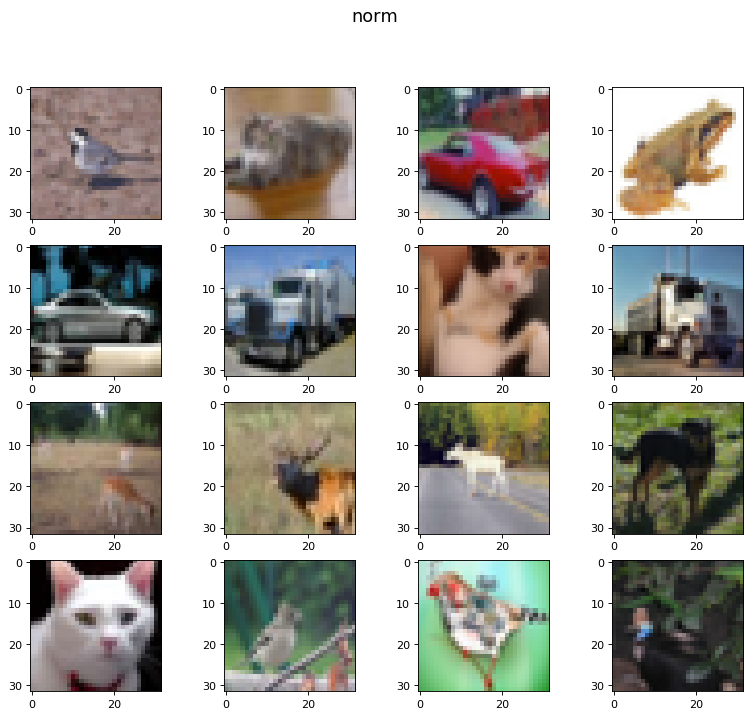

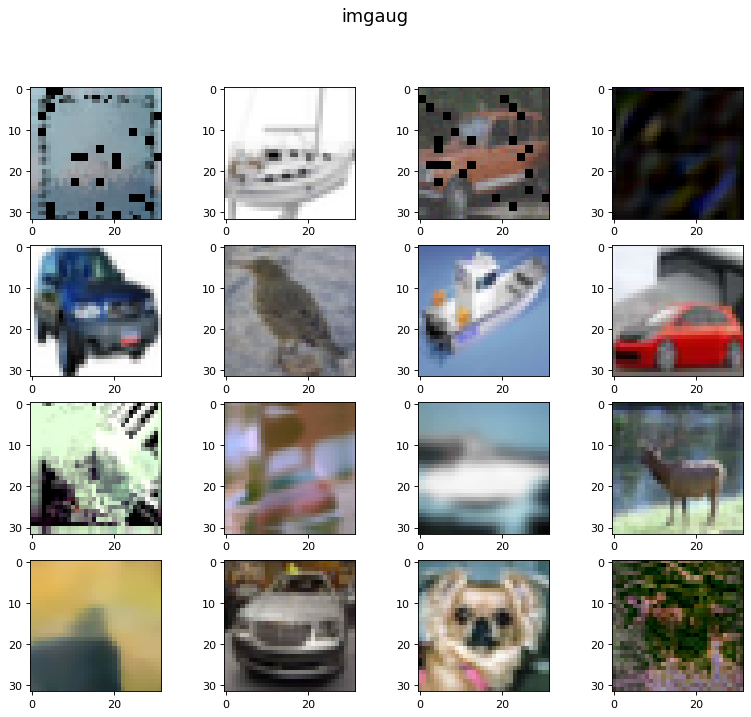

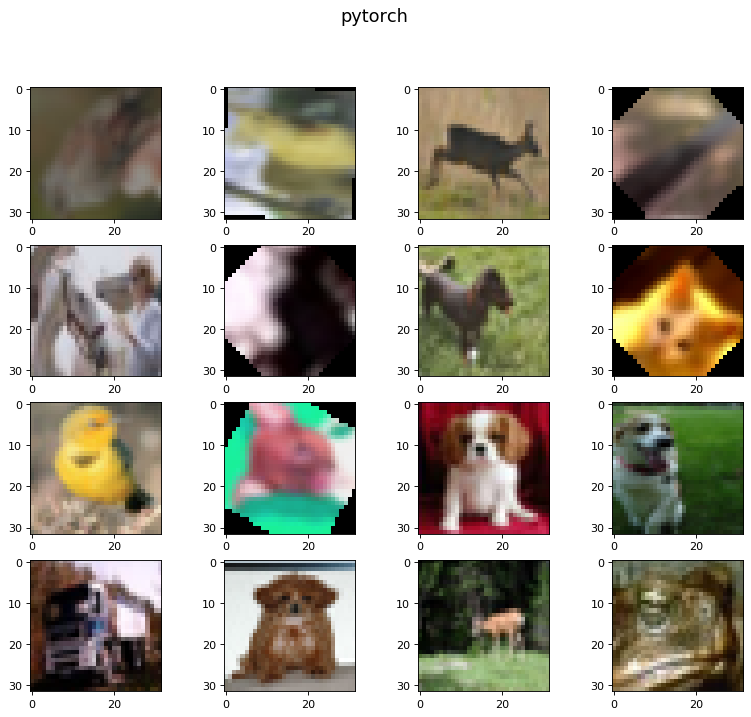

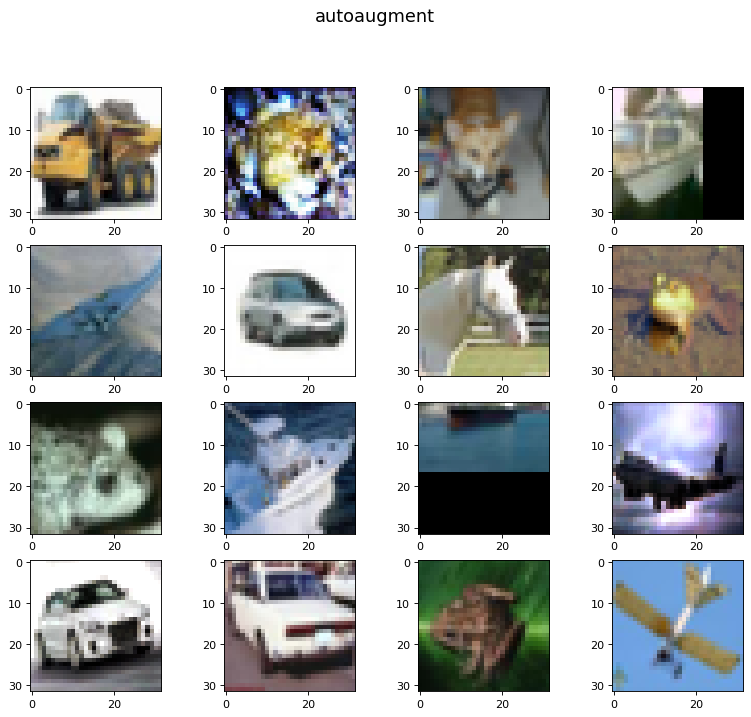

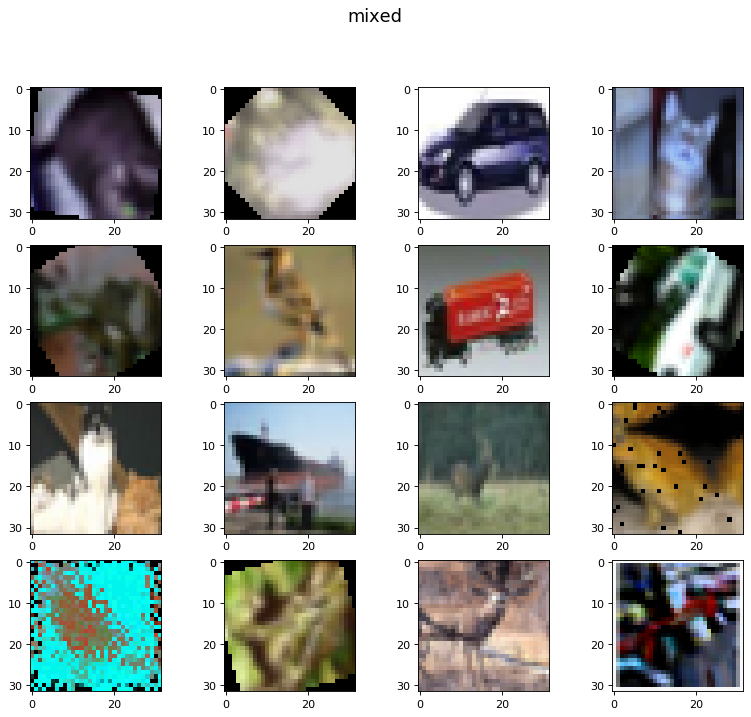

In [30]:

n=16

for key in all_trainsets:
    loader = get_preprocessed_train_loader(all_trainsets[key])
    dataiter = iter(loader)
    #Can contain the augmentations or not !!!
    plotSomeImages(n, dataiter, key)

# Training
The code that trains the given model. Based on the preprocessed data that is stored on disk. The storing of tensors and rereading them adds another layer of tensor packing. This has to be taken care of. After that the training is just like any other training with validation between epochs.

In [0]:
import time
import torch.optim as optim
import numpy as np


def createLossAndOptimizer(net, learning_rate=0.001):
    
    #Loss function
    loss = torch.nn.CrossEntropyLoss()
    #loss = torch.nn.NLLLoss()
    
    
    #Optimizer
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    return(loss, optimizer)

#def trainNet(net, dataset_name, trainset, batch_size, n_epochs, learning_rate):
def trainNet(net, dataset_name, train_loader, preprocessed, batch_size, n_epochs, learning_rate):
    
    training_losses = {}
    validation_losses = {}
    
    type_name = dataset_name

    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("trainset=", type_name)
    
    
    #train_loader = trainset # Given the loaders directly
    #train_loader = get_preprocessed_train_loader(trainset)
    
    print("Length train loader (batches)= " + str(len(train_loader)))
    print("=" * 30)
    
    n_batches = len(train_loader)
    
    #Create our loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)

    #Create a multi step elarning rate
    #scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=np.linspace(10,n_epochs, 10), gamma=0.1)

    #Time for printing
    training_start_time = time.time()

    training_losses = []
    validation_losses = []
    validation_accuracy = []

    total_train_loss = 0

    #Loop for n_epochs
    for j, epoch in enumerate(range(n_epochs), 0):

        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        #total_train_loss = 0
        
        if(preprocessed):
          iterable = train_loader
        else:
          iterable = train_loader.dataset

        #for i, data in enumerate(trainset, 0):
        for i, data in enumerate(train_loader, 0):
        #for i, data in enumerate(iterable, 0):
            
            
            #Get inputs
            #inputs, labels = data

            #Take care of double packed tensor data
            if(preprocessed):
              inputs = data[0][0]
              labels = data[1][0]
            else:
              inputs, labels = data
              
              
              



            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)

            inputs = inputs.to(device)
            labels = labels.to(device)

            #Set the parameter gradients to zero
            optimizer.zero_grad()

            #Forward pass, backward pass, optimize
            outputs = net(inputs)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            

            #Print statistics

            running_loss += loss_size.data
            total_train_loss += loss_size.data


            training_losses.append(total_train_loss / ((j * n_batches) + (i+1)))


            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()

        #At the end of the epoch, do a pass on the validation set
        val_loader = test_loader
        total_val_loss = 0
        correct = 0
        for inputs, labels in val_loader:

            #Wrap tensors in Variables
            inputs, labels = Variable(inputs), Variable(labels)

            inputs = inputs.to(device)
            labels = labels.to(device)

            #Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, labels)
            total_val_loss += val_loss_size.data

            #Accuracy
            _, predicted = torch.max(val_outputs, 1)
            #acc += (predicted == labels).squeeze()

                    
            correct += (predicted == labels).float().sum()
            

        #Learning rate step
        #scheduler.step()

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

        validation_losses.append(total_val_loss / len(val_loader))

        #Show the accuracy
        acc = correct / (VAL_LOADER_BATCH_SIZE * len(val_loader)) * 100
        print("Accuracy = {:.2f}%".format(acc))
        validation_accuracy.append(acc)

        print("Training epoch finished, took {:.2f}s".format(time.time() - training_start_time))
        

    return training_losses, validation_losses, validation_accuracy
    
        

# Get different pretrained models to finetune

In [0]:
'''
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
'''

'\ndef set_parameter_requires_grad(model, feature_extracting):\n    if feature_extracting:\n        for param in model.parameters():\n            param.requires_grad = False\n'

In [0]:
'''
import torchvision.models as models

NUM_CLASSES = 10 # CIFAR10 has 10 classes

resnet18 = models.resnet18(pretrained=True)
#set_parameter_requires_grad(resnet18, True)
resnet18.fc = torch.nn.Linear(512, NUM_CLASSES)


densenet = models.densenet161()
#set_parameter_requires_grad(densenet, True)
densenet.classifier = torch.nn.Linear(1024, NUM_CLASSES)


alexnet = models.alexnet(pretrained=True)
#set_parameter_requires_grad(alexnet, True)
alexnet.classifier[6] = torch.nn.Linear(4096,NUM_CLASSES)

vgg16 = models.vgg16(pretrained=True)
#set_parameter_requires_grad(vgg16, True)
vgg16.classifier[6] = torch.nn.Linear(4096,NUM_CLASSES)

'''

'\nimport torchvision.models as models\n\nNUM_CLASSES = 10 # CIFAR10 has 10 classes\n\nresnet18 = models.resnet18(pretrained=True)\n#set_parameter_requires_grad(resnet18, True)\nresnet18.fc = torch.nn.Linear(512, NUM_CLASSES)\n\n\ndensenet = models.densenet161()\n#set_parameter_requires_grad(densenet, True)\ndensenet.classifier = torch.nn.Linear(1024, NUM_CLASSES)\n\n\nalexnet = models.alexnet(pretrained=True)\n#set_parameter_requires_grad(alexnet, True)\nalexnet.classifier[6] = torch.nn.Linear(4096,NUM_CLASSES)\n\nvgg16 = models.vgg16(pretrained=True)\n#set_parameter_requires_grad(vgg16, True)\nvgg16.classifier[6] = torch.nn.Linear(4096,NUM_CLASSES)\n\n'

# Train the network

In [27]:
import torchvision.models as models

all_training_losses = {}
all_validation_losses = {}
all_validation_accuracy = {}
all_models = {}

all_dataloaders = {}

#ppds_trainsets = {'norm' : get_train_loader(BATCH_SIZE, train_set_norm),
#                  'imgaug' : get_train_loader(BATCH_SIZE, train_set_imgaug),
#                  'pytorch' : get_train_loader(BATCH_SIZE, train_set_pytorch),
#                  'autoaugment' : get_preprocessed_train_loader(ppds_trainsets['autoaugment']),
#                  'mixed' : get_preprocessed_train_loader(ppds_trainsets['mixed'])}



for key in all_trainsets_preprocessed:
  if(all_trainsets_preprocessed[key] == True):
    all_dataloaders[key] = get_preprocessed_train_loader(all_trainsets[key])
  else:
    all_dataloaders[key] = get_train_loader(BATCH_SIZE, all_trainsets[key])


#for key in ppds_trainsets:
for key in all_dataloaders:
    model = SmallNet()
    #model = densenet

    model = model.cuda(device)
    #training_losses, validation_losses = trainNet(model, key, ppds_trainsets[key], batch_size=BATCH_SIZE, n_epochs=N_EPOCHS, learning_rate=LEARNING_RATE)
    training_losses, validation_losses, validation_accuracy = trainNet(model, key, all_dataloaders[key], preprocessed=all_trainsets_preprocessed[key], batch_size=BATCH_SIZE, n_epochs=N_EPOCHS, learning_rate=LEARNING_RATE)
    all_training_losses[key] = training_losses
    all_validation_losses[key] = validation_losses
    all_validation_accuracy[key] = validation_accuracy

    #save the model
    all_models[key] = model




===== HYPERPARAMETERS =====
batch_size= 32
epochs= 50
learning_rate= 0.00025
trainset= norm
Length train loader (batches)= 1563
Epoch 1, 10% 	 train_loss: 2.64 took: 1.54s
Epoch 1, 20% 	 train_loss: 2.22 took: 1.32s
Epoch 1, 30% 	 train_loss: 2.11 took: 1.31s
Epoch 1, 40% 	 train_loss: 2.00 took: 1.33s
Epoch 1, 50% 	 train_loss: 1.95 took: 1.32s
Epoch 1, 60% 	 train_loss: 1.94 took: 1.34s
Epoch 1, 70% 	 train_loss: 1.89 took: 1.33s
Epoch 1, 80% 	 train_loss: 1.84 took: 1.31s
Epoch 1, 90% 	 train_loss: 1.82 took: 1.31s
Validation loss = 1.81
Accuracy = 33.52%
Training epoch finished, took 17.06s
Epoch 2, 10% 	 train_loss: 1.77 took: 1.45s
Epoch 2, 20% 	 train_loss: 1.79 took: 1.33s
Epoch 2, 30% 	 train_loss: 1.76 took: 1.31s
Epoch 2, 40% 	 train_loss: 1.74 took: 1.31s
Epoch 2, 50% 	 train_loss: 1.73 took: 1.33s
Epoch 2, 60% 	 train_loss: 1.73 took: 1.32s
Epoch 2, 70% 	 train_loss: 1.73 took: 1.31s
Epoch 2, 80% 	 train_loss: 1.70 took: 1.32s
Epoch 2, 90% 	 train_loss: 1.68 took: 1.34s
Va

# Results compared

Text(0.5, 1.0, 'Accuracy')

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


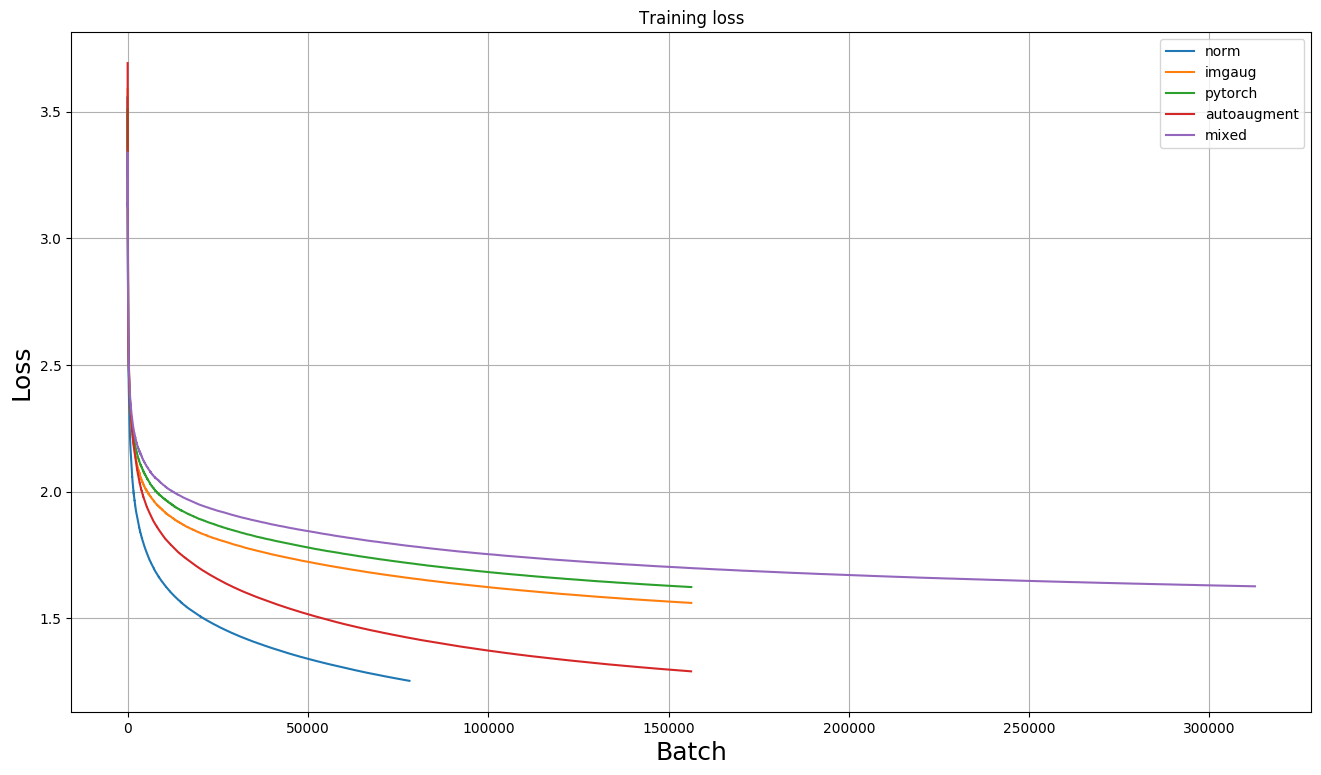

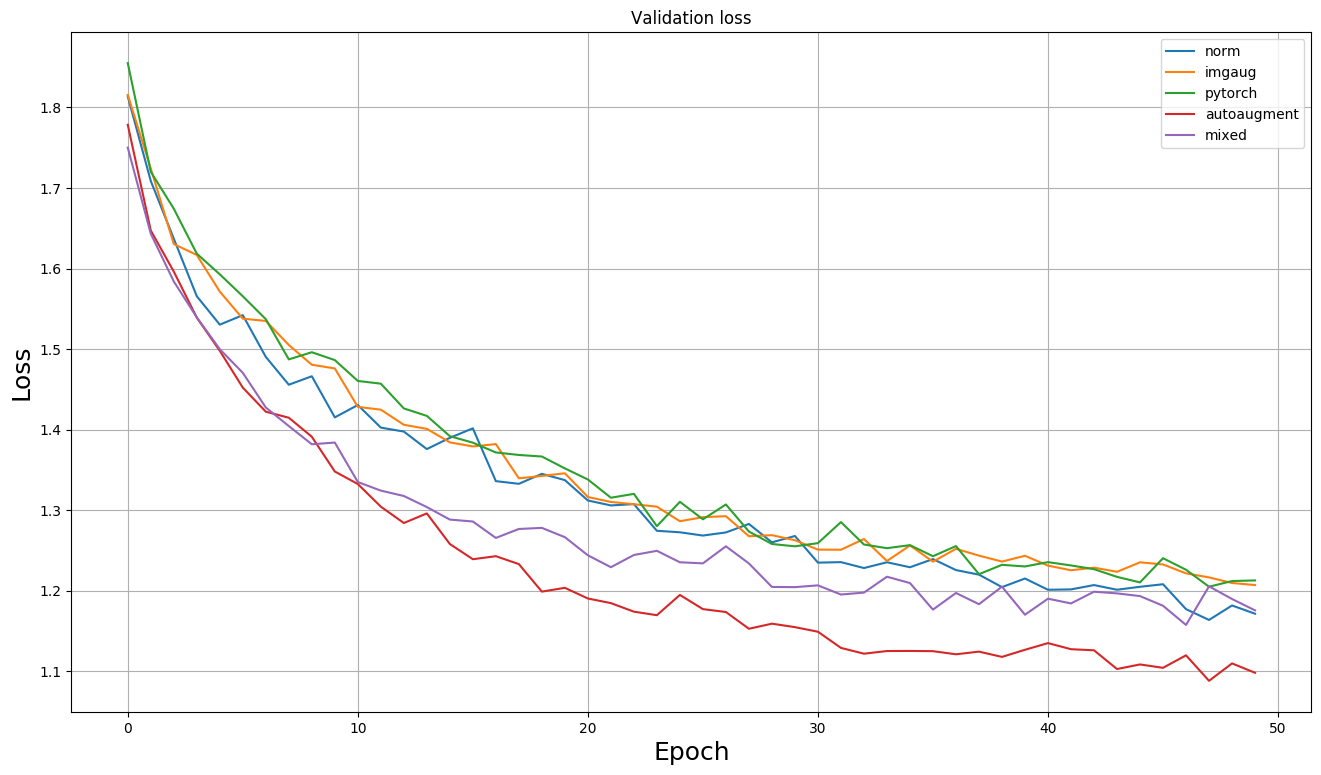

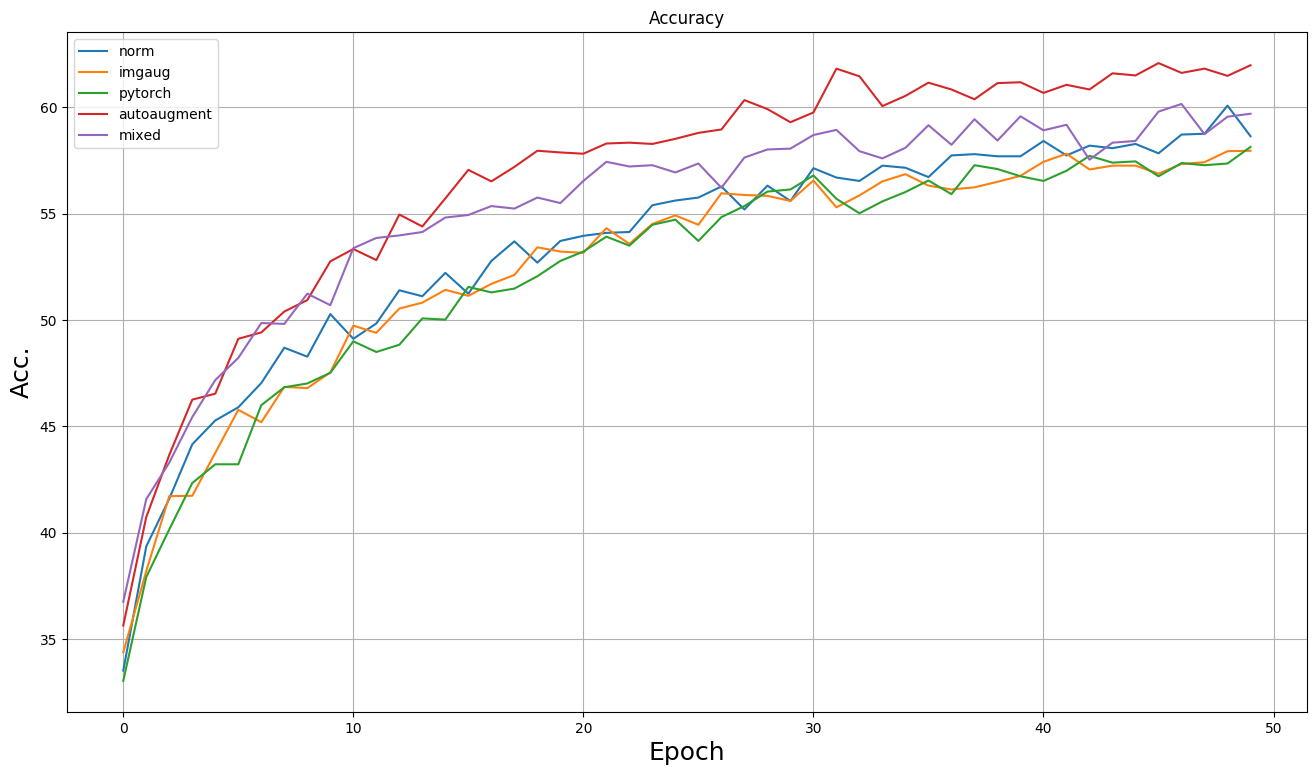

In [28]:
#Plot the training losses
plt.figure(1, figsize=(16, 9), dpi=100)
for key in all_training_losses:
    plt.plot(all_training_losses[key])
plt.xlabel('Batch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.grid()
plt.legend(all_training_losses.keys())
plt.title('Training loss')

#Plot the epoch losses                                                   
plt.figure(2, figsize=(16, 9), dpi=100)
for key in all_validation_losses:
    plt.plot(all_validation_losses[key])
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.grid()
plt.grid(which='minor')
plt.legend(all_validation_losses.keys())
plt.title('Validation loss')

#Plot the accuracy                                               
plt.figure(3, figsize=(16, 9), dpi=100)
for key in all_validation_accuracy:
    plt.plot(all_validation_accuracy[key])
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Acc.', fontsize=18)
plt.grid()
plt.grid(which='minor')
plt.legend(all_validation_accuracy.keys())
plt.title('Accuracy')

In [29]:
classes = test_loader.dataset.classes

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for key in all_models:
    print('Model name: ' + key)
    model = all_models[key]
    for data in test_loader:
      images, labels = data
      images = images.cuda()
      labels = labels.cuda()
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      c = (predicted == labels).squeeze()
      for i in range(len(labels)):
        #print(label.item())
        label = labels[i].item()
        class_correct[label] += c[i].item()
        class_total[label] += 1


    for i in range(10):
      print('Accuracy of %5s : %2d %%' % (
      classes[i], 100 * class_correct[i] / class_total[i]))

Model name: norm
Accuracy of airplane : 60 %
Accuracy of automobile : 74 %
Accuracy of  bird : 43 %
Accuracy of   cat : 44 %
Accuracy of  deer : 49 %
Accuracy of   dog : 42 %
Accuracy of  frog : 61 %
Accuracy of horse : 67 %
Accuracy of  ship : 75 %
Accuracy of truck : 67 %
Model name: imgaug
Accuracy of airplane : 61 %
Accuracy of automobile : 76 %
Accuracy of  bird : 42 %
Accuracy of   cat : 41 %
Accuracy of  deer : 44 %
Accuracy of   dog : 44 %
Accuracy of  frog : 62 %
Accuracy of horse : 66 %
Accuracy of  ship : 74 %
Accuracy of truck : 66 %
Model name: pytorch
Accuracy of airplane : 60 %
Accuracy of automobile : 74 %
Accuracy of  bird : 42 %
Accuracy of   cat : 40 %
Accuracy of  deer : 46 %
Accuracy of   dog : 45 %
Accuracy of  frog : 64 %
Accuracy of horse : 64 %
Accuracy of  ship : 74 %
Accuracy of truck : 65 %
Model name: autoaugment
Accuracy of airplane : 62 %
Accuracy of automobile : 75 %
Accuracy of  bird : 44 %
Accuracy of   cat : 40 %
Accuracy of  deer : 48 %
Accuracy of  